Загрузка и предобработка

In [11]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 1. Загрузка и предобработка данных
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Нормализация данных
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Изменение размерности данных
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

Создание поврежденных изображений

In [12]:
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

Создание сверточного автоэнкодера

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Input

input_img = layers.Input(shape=(28, 28, 1))

# Создание энкодера
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)

# Запоминание размерности перед Flatten
shape_before_flatten = tf.keras.backend.int_shape(x)[1:]
x = Flatten()(x)
encoded = Dense(64, activation='relu')(x)

# Создание декодера
x = Dense(np.prod(shape_before_flatten), activation='relu')(encoded)
x = Reshape(shape_before_flatten)(x)
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same', strides=(2, 2))(x)
decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

# Создание модели автоэнкодера
autoencoder = Model(input_img, decoded)

Обучение автоэнкодера

In [17]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train_noisy, x_train,
                epochs=2,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))


Epoch 1/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 115s 242ms/step - loss: 0.0747 - val_loss: 0.0173
Epoch 2/2
469/469 ━━━━━━━━━━━━━━━━━━━━ 112s 239ms/step - loss: 0.0158 - val_loss: 0.0127


Оценка результатов

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


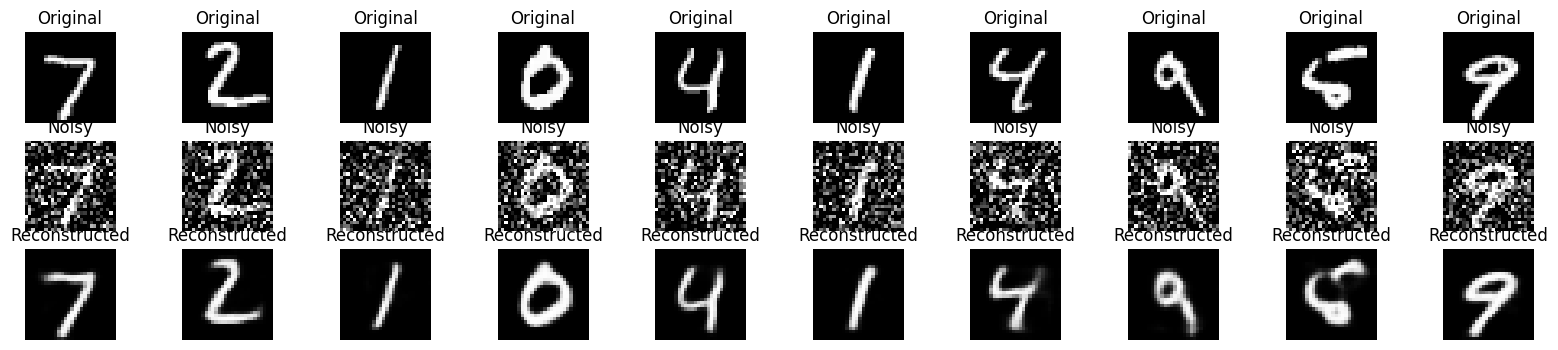

In [18]:
decoded_imgs = autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Оригинальные изображения
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Зашумленные изображения
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Восстановленные изображения
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.show()